In [51]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os
opj = os.path.join
CODE_DIR = os.path.abspath('../..')
sys.path.append(opj(CODE_DIR, 'EPypes'))
sys.path.append(opj(CODE_DIR, 'RPALib'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import numpy as np
from PIL import Image
from io import BytesIO
from glob import glob
from matplotlib import pyplot as plt
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

from epypes.compgraph import CompGraph, graph_union
from epypes.pipeline import Pipeline, attach
from rpa import cbcalib

In [53]:
images_mask = opj(CODE_DIR, 'DATA/IMG/calib/opencv_left/*.jpg')
imfiles = glob(images_mask)

In [54]:
im = open(imfiles[0], 'rb').read()
ba = bytearray(im)

In [55]:
def read_file(fname):
    return open(fname, 'rb').read()
    
class PrepareBytearray(CompGraph):
    
    def __init__(self):
        
        func_dict = {
            'read_file': read_file,
            'create_bytearray': bytearray
        }

        func_io = {
            'read_file': ('filename', 'file_content'),
            'create_bytearray': ('file_content', 'file_bytearray')
        }

        super(PrepareBytearray, self).__init__(func_dict, func_io)

In [56]:
g_ba = PrepareBytearray()
g_cb = cbcalib.CGFindCorners()

In [57]:
pipe_ba = Pipeline('PrepareBytearray', g_ba)

In [58]:
pipe_ba.runner.required_source_tokens

{'filename'}

In [59]:
pipe_ba.run(filename=imfiles[0])
#pipe_ba.token_value('file_bytearray')

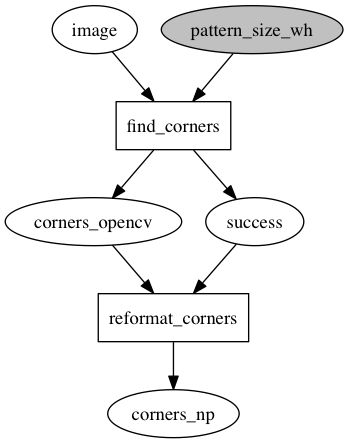

In [60]:
pipe_cb = Pipeline('ChessboardCorners', g_cb)
pipe_cb.runner.token_manager.freeze_token('pattern_size_wh', (9, 6))

nxpd.draw(pipe_cb.runner.token_manager.to_networkx())

In [61]:
def open_image_from_bytesarray(ba):
    buff = BytesIO(ba)
    im = np.array(Image.open(buff))
    return im

g_u = graph_union(g_ba, 
                  g_cb, 
                  {'create_bytesio': BytesIO, 'open_image_from_bytesio': Image.open, 'im_to_np': np.array},
                  {
                      'create_bytesio': ('file_bytearray', 'b_io'),
                      'open_image_from_bytesio': ('b_io', 'pil_im'),
                      'im_to_np': ('pil_im', 'image')
                  }
                 )

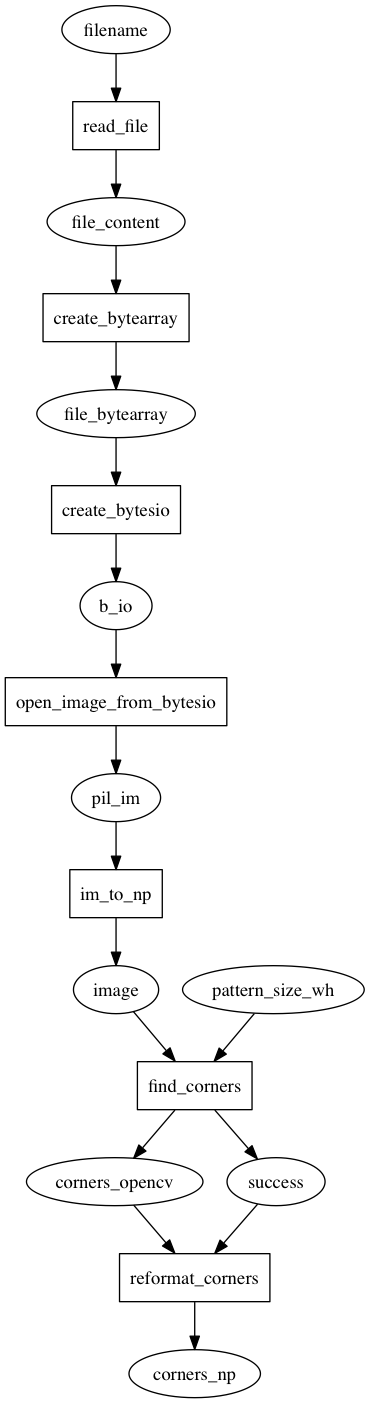

In [62]:
nxpd.draw(g_u.to_networkx())

In [63]:
pipe_u = Pipeline('WholeStuff', g_u)
pipe_u.runner.token_manager.freeze_token('pattern_size_wh', (9, 6))

pipe_u.run(filename=imfiles[0])

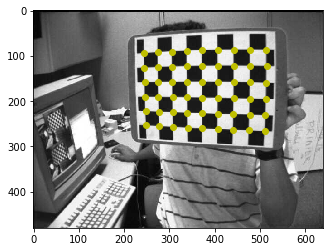

In [64]:
plt.gray()
plt.imshow(pipe_u.token_value('image'))
plt.plot(pipe_u.token_value('corners_np')[:, 0], pipe_u.token_value('corners_np')[:, 1], 'yo')

In [65]:
pipe_u.traverse_time()

('WholeStuff',
 0.018031835556030273,
 (('read_file', 0.0003390312194824219),
  ('create_bytearray', 6.29425048828125e-05),
  ('find_corners', 0.005782127380371094),
  ('reformat_corners', 3.1948089599609375e-05),
  ('create_bytesio', 0.00010204315185546875),
  ('open_image_from_bytesio', 0.00191497802734375),
  ('im_to_np', 0.009536027908325195)))

In [66]:
pipe_u.compute_overhead()

0.0002627372741699219